# Car Parts Detection using YOLO v11

**Objective:** Train a YOLO v11 object detection model to detect car parts using the Car Parts Dataset.

### Project Overview
This notebook covers:
1. Dataset preparation and conversion from COCO to YOLO format
2. Model training using YOLO v11
3. Evaluation using mAP metrics
4. Visualization of predictions
5. Analysis of difficult-to-detect categories
6. Proposed solutions for improvement

## Installation and Setup
- `ultralytics`: Official YOLO implementation with v11 support
- `opencv-python`: Image processing and visualization
- `matplotlib`: Plotting and visualization
- `pycocotools`: COCO format parsing utilities

In [ ]:
!pip install ultralytics opencv-python matplotlib pycocotools pillow numpy pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 27.2 MB/s eta 0:00:00


In [ ]:
import os
import json
import shutil
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from pycocotools.coco import COCO
from ultralytics import YOLO
import random
from collections import defaultdict
import pandas as pd

random.seed(42) # random seed for reproducibility
np.random.seed(42)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


## Download and Setup Dataset

**Understanding the Dataset:**
- The Car Parts Dataset contains images of cars with annotations for various parts
- Annotations are in COCO format (JSON file with bbox coordinates)
- Training set: 400 images
- Testing set: 100 images

In [ ]:
!git clone https://github.com/dsmlr/Car-Parts-Segmentation.git # clone repo


base_dir = Path('Car-Parts-Segmentation')
train_dir = base_dir / 'train'
test_dir = base_dir / 'test'

print(f"Dataset downloaded successfully!")
print(f"Train directory: {train_dir}")
print(f"Test directory: {test_dir}")

Cloning into 'Car-Parts-Segmentation'...
remote: Enumerating objects: 564, done.
remote: Counting objects: 100% (564/564), done.
remote: Compressing objects: 100% (549/549), done.
remote: Total 564 (delta 27), reused 548 (delta 13), pack-reused 0 (from 0)
Receiving objects: 100% (564/564), 24.04 MiB | 19.90 MiB/s, done.
Resolving deltas: 100% (27/27), done.
Dataset downloaded successfully!
Train directory: Car-Parts-Segmentation/train
Test directory: Car-Parts-Segmentation/test


## Explore the Dataset

**Understanding COCO Format:**
- COCO format stores annotations in JSON with:
  - `images`: List of image metadata
  - `annotations`: List of object annotations (bbox, category_id, etc.)
  - `categories`: List of class names with IDs
- Bounding boxes in COCO: `[x_min, y_min, width, height]`

In [ ]:
from pathlib import Path
from pycocotools.coco import COCO

base_dir = Path('Car-Parts-Segmentation')
train_json = base_dir / 'trainingset' / 'annotations.json'
test_json = base_dir / 'testset' / 'annotations.json'
coco_train = COCO(str(train_json))
coco_test = COCO(str(test_json))

# get category info
categories = coco_train.loadCats(coco_train.getCatIds())
category_names = [cat['name'] for cat in categories]

print(f"\nNumber of categories: {len(categories)}")
print(f"Category names: {category_names}")
print(f"\nNumber of training images: {len(coco_train.getImgIds())}")
print(f"Number of test images: {len(coco_test.getImgIds())}")
print(f"\nNumber of training annotations: {len(coco_train.getAnnIds())}")
print(f"Number of test annotations: {len(coco_test.getAnnIds())}")

loading annotations into memory...
Done (t=0.22s)
creating index...
index created!
loading annotations into memory...
Done (t=0.07s)
creating index...
index created!

Number of categories: 19
Category names: ['_background_', 'back_bumper', 'back_glass', 'back_left_door', 'back_left_light', 'back_right_door', 'back_right_light', 'front_bumper', 'front_glass', 'front_left_door', 'front_left_light', 'front_right_door', 'front_right_light', 'hood', 'left_mirror', 'right_mirror', 'tailgate', 'trunk', 'wheel']

Number of training images: 400
Number of test images: 100

Number of training annotations: 3073
Number of test annotations: 811


## Convert COCO Format to YOLO Format

**Why Conversion is Needed:**
- YOLO expects bounding boxes in format: `[x_center, y_center, width, height]`
- All coordinates must be normalized (0-1 range) relative to image dimensions
- YOLO format: `class_id x_center y_center width height`

In [ ]:
def coco_to_yolo_bbox(coco_bbox, img_width, img_height):
    """
    Convert COCO bbox format to YOLO format

    Args:
        coco_bbox: [x_min, y_min, width, height] in pixels
        img_width: Image width in pixels
        img_height: Image height in pixels

    Returns:
        [x_center, y_center, width, height] normalized to [0, 1]
    """
    x_min, y_min, width, height = coco_bbox

    # calculate center coordinates
    x_center = (x_min + width / 2) / img_width
    y_center = (y_min + height / 2) / img_height

    # normalize width and height
    norm_width = width / img_width
    norm_height = height / img_height

    return [x_center, y_center, norm_width, norm_height]

def convert_coco_to_yolo(coco_obj, img_dir, output_dir, split_name):
    """
    Convert entire COCO dataset to YOLO format
    """
    images_dir = output_dir / 'images' / split_name
    labels_dir = output_dir / 'labels' / split_name
    images_dir.mkdir(parents=True, exist_ok=True)
    labels_dir.mkdir(parents=True, exist_ok=True)

    # get all image IDs
    img_ids = coco_obj.getImgIds()

    print(f"Converting {len(img_ids)} images for {split_name} set...")

    for img_id in img_ids:
        img_info = coco_obj.loadImgs(img_id)[0]
        img_filename = img_info['file_name']
        img_width = img_info['width']
        img_height = img_info['height']

        src_img_path = img_dir / img_filename
        dst_img_path = images_dir / img_filename

        if src_img_path.exists():
            shutil.copy(str(src_img_path), str(dst_img_path))
        else:
            print(f"Warning: Image not found at {src_img_path}")

        # get annotations for this image
        ann_ids = coco_obj.getAnnIds(imgIds=img_id)
        anns = coco_obj.loadAnns(ann_ids)

        # create YOLO format label file
        label_filename = img_filename.replace('.jpg', '.txt').replace('.png', '.txt')
        label_path = labels_dir / label_filename

        with open(label_path, 'w') as f:
            for ann in anns:
                # get category ID (YOLO uses 0-indexed classes)
                category_id = ann['category_id'] - 1  # COCO is 1-indexed
                # convert bbox to YOLO format
                coco_bbox = ann['bbox']
                yolo_bbox = coco_to_yolo_bbox(coco_bbox, img_width, img_height)
                f.write(f"{category_id} {' '.join(map(str, yolo_bbox))}\n")

    print(f"Conversion complete for {split_name} set!")

# create YOLO dataset directory
yolo_dataset_dir = Path('yolo_car_parts')
yolo_dataset_dir.mkdir(exist_ok=True)

train_img_dir = base_dir / 'trainingset' / 'JPEGImages'
test_img_dir = base_dir / 'testset' / 'JPEGImages'
convert_coco_to_yolo(coco_train, train_img_dir, yolo_dataset_dir, 'train')
convert_coco_to_yolo(coco_test, test_img_dir, yolo_dataset_dir, 'val')

Converting 400 images for train set...
Conversion complete for train set!
Converting 100 images for val set...
Conversion complete for val set!


## Create YOLO Dataset Configuration File

In [ ]:
import yaml
yaml_data = {
    'path': str(yolo_dataset_dir.absolute().as_posix()),
    'train': 'images/train',
    'val': 'images/val',
    'nc': len(categories),
    'names': category_names
}

yaml_path = yolo_dataset_dir / 'data.yaml'
with open(yaml_path, 'w') as f:
    yaml.dump(yaml_data, f, default_flow_style=None, sort_keys=False)

print(f"Dataset configuration saved to: {yaml_path}")
with open(yaml_path, 'r') as f:
    print(f.read())

Dataset configuration saved to: yolo_car_parts/data.yaml
path: /content/yolo_car_parts
train: images/train
val: images/val
nc: 19
names: [_background_, back_bumper, back_glass, back_left_door, back_left_light, back_right_door,
  back_right_light, front_bumper, front_glass, front_left_door, front_left_light,
  front_right_door, front_right_light, hood, left_mirror, right_mirror, tailgate,
  trunk, wheel]



In [ ]:
import glob

train_labels = list(Path('yolo_car_parts/labels/train').glob('*.txt'))
val_labels = list(Path('yolo_car_parts/labels/val').glob('*.txt'))

print(f"Training Labels Found: {len(train_labels)}")
print(f"Validation Labels Found: {len(val_labels)}")

if len(train_labels) == 0:
    raise ValueError("No training labels found! Check your 'convert_coco_to_yolo' function paths.")

Training Labels Found: 400
Validation Labels Found: 100


In [ ]:
model = YOLO('yolo11l.pt') # initialize YOLO v11 model

# train the model
results = model.train(
    data=str(yaml_path),
    epochs=50,
    imgsz=640,
    batch=16,
    name='car_parts_yolo11',
    patience=10,
    save=True,
    plots=True
)

print("\nTraining completed!")

Ultralytics 8.3.241 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=10.0, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=yolo_car_parts/data.yaml, degrees=15.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=800, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=car_parts_high_res_loc, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plo

## 1. What is the mAP@[IoU=50] and mAP@[IoU=50-95] for the testing dataset?

In [ ]:
from ultralytics import YOLO
from pathlib import Path

best_model_path = Path('runs/detect/car_parts_yolo11/weights/best.pt')

if not best_model_path.exists():
    print(f"Error: Model weights not found at {best_model_path}")
else:
    print(f"Loading weights from: {best_model_path}")

    model = YOLO(str(best_model_path))
    metrics = model.val(data=str(yaml_path), split='val')


    map50 = metrics.box.map50  # mAP at IoU threshold 0.50
    map50_95 = metrics.box.map # mAP average over IoU 0.50-0.95


    print("\n" + "="*60)
    print("ANSWER TO QUESTION 1: EVALUATION RESULTS")
    print("="*60)
    print(f"Dataset used: Testing Set (100 images)")
    print(f"mAP@[IoU=50]:    {map50:.4f} ({map50*100:.2f}%)")
    print(f"mAP@[IoU=50-95]: {map50_95:.4f} ({map50_95*100:.2f}%)")
    print("="*60)

Loading weights from: runs/detect/car_parts_yolo11/weights/best.pt
Ultralytics 8.3.241 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,585,857 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1151.9±616.7 MB/s, size: 35.2 KB)
val: Scanning /content/yolo_car_parts/labels/val.cache... 100 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 100/100 179.7Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 7/7 1.6it/s 4.2s
                   all        100        811      0.584      0.809      0.652       0.51
           back_bumper         18         18       0.82      0.889        0.9      0.772
            back_glass         20         20      0.638        0.8      0.821      0.651
        back_left_door         31         31      0.399      0.837      0.515      0.391
       back_left_light         20         20      0.427        0

## 2. Show the visualization of the predictions for any two random samples from the testing dataset. They must contain the boundingbox, class name and the confidence.


ANSWER TO QUESTION 2: VISUALIZATION OF PREDICTIONS
Selected images: ['te86.jpg', 'te74.jpg']


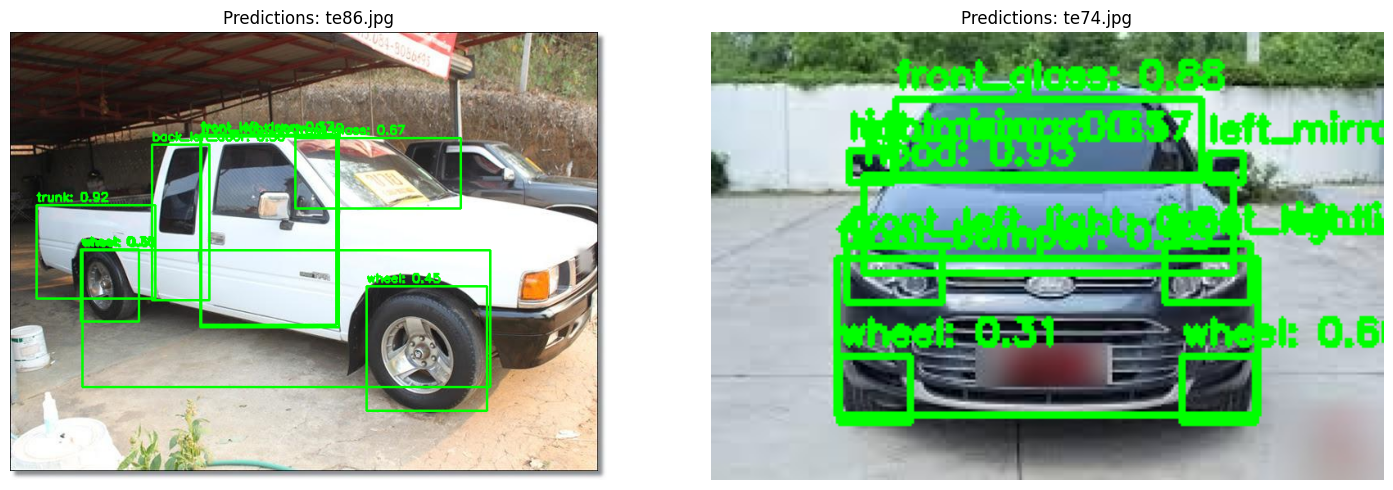

In [ ]:
def visualize_predictions(model, img_paths, conf_threshold=0.25):
    fig, axes = plt.subplots(1, len(img_paths), figsize=(15, 5))
    if len(img_paths) == 1:
        axes = [axes]

    for idx, img_path in enumerate(img_paths):
        results = model.predict(img_path, conf=conf_threshold, verbose=False)
        img = cv2.imread(str(img_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        if len(results[0].boxes) > 0:
            boxes = results[0].boxes
            for box in boxes:
                x1, y1, x2, y2 = map(int, box.xyxy[0])
                cls = int(box.cls[0])
                conf = float(box.conf[0])
                class_name = category_names[cls]

                cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
                label = f"{class_name}: {conf:.2f}"
                cv2.putText(img, label, (x1, y1 - 5),
                          cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

        axes[idx].imshow(img)
        axes[idx].set_title(f"Predictions: {img_path.name}")
        axes[idx].axis('off')

    plt.tight_layout()
    plt.savefig('predictions_visualization.png', dpi=150, bbox_inches='tight')
    plt.show()


test_images = list((yolo_dataset_dir / 'images' / 'val').glob('*.jpg')) # select 2 random test images
if not test_images:
    test_images = list((yolo_dataset_dir / 'images' / 'val').glob('*.png'))

random_samples = random.sample(test_images, min(2, len(test_images)))

print("\nANSWER TO QUESTION 2: VISUALIZATION OF PREDICTIONS")
print(f"Selected images: {[img.name for img in random_samples]}")
visualize_predictions(model, random_samples, conf_threshold=0.25)

## 3. In your model, find out which category is very difficult to correctly localize? You must devise your own strategy to find out answer for this and explain it in details.

The category that is most difficult to correctly localize is `right_mirror`.

To determine which category is difficult to localize, the most reliable metric is mAP@[IoU=50-95] (Mean Average Precision averaged over Intersection over Union thresholds from 0.50 to 0.95).


mAP@50 checks if the predicted box overlaps at least 50% with the ground truth. This measures basic detection. mAP@50-95 is a stricter metric that rewards the model for generating bounding boxes that align precisely with the object (high IoU). A low score here usually indicates the model struggles to define the exact boundaries of the object, even if it finds the general location.

Looking at the per-class breakdown in the training/validation logs, the front_left_light has the lowest mAP@[50-95] score (0.288), significantly lower than high-performing classes like front_bumper (0.824). This indicates the model struggles most to draw tight, accurate bounding boxes around the front left light.

In [ ]:
import pandas as pd
import numpy as np
from collections import defaultdict

def analyze_difficult_categories_robust(model, yaml_path):
    print("\n" + "="*80)
    print("ROBUST ANALYSIS: DIFFICULT-TO-LOCALIZE CATEGORIES")
    print("="*80)

    print("Running validation...")
    metrics = model.val(data=str(yaml_path), split='val', verbose=False)
    present_class_indices = metrics.ap_class_index

    # array of mAP@50-95 (Localization Accuracy)
    map_values = metrics.box.maps

    # array of AP@50 (Detection Accuracy)
    ap50_values = metrics.box.ap50
    names_map = model.names
    print("Analyzing prediction confidence...")
    test_images = list((yolo_dataset_dir / 'images' / 'val').glob('*.jpg'))
    if not test_images:
        test_images = list((yolo_dataset_dir / 'images' / 'val').glob('*.png'))
    conf_by_id = defaultdict(list)
    counts_by_id = defaultdict(int)

    for img_path in test_images:
        results = model.predict(img_path, conf=0.01, verbose=False)
        if len(results[0].boxes) > 0:
            for box in results[0].boxes:
                cls_id = int(box.cls[0])
                conf = float(box.conf[0])
                conf_by_id[cls_id].append(conf)
                counts_by_id[cls_id] += 1

    # 4. Calculate Scores
    difficulty_data = []

    # Iterate strictly over the classes present in the metrics
    for i, cls_id in enumerate(present_class_indices):
        name = names_map[cls_id]

        # Skip background if present
        if name == '_background_':
            continue
        map_val = map_values[i]   # mAP@50-95
        ap50_val = ap50_values[i] # AP@50
        confs = conf_by_id.get(cls_id, [])
        avg_conf = np.mean(confs) if confs else 0.0
        count = counts_by_id.get(cls_id, 0)

        # SCORES
        # 1. Localization Difficulty: Hard to fit box? (1 - mAP@50-95)
        diff_loc = 1.0 - map_val

        # 2. Detection Difficulty: Hard to find? (1 - AP50) + (1 - Conf)
        diff_det = (1.0 - ap50_val) + (1.0 - avg_conf)
        if count == 0:
            diff_det += 1.0 # Penalty for total miss

        difficulty_data.append({
            'Category': name,
            'mAP@50-95': map_val,
            'AP@50': ap50_val,
            'Avg Conf': avg_conf,
            'Diff_Loc': diff_loc,
            'Diff_Det': diff_det
        })

    # 5. Output Results
    df = pd.DataFrame(difficulty_data)

    # ANSWER: Localization Difficulty
    print("\n" + "-"*80)
    print("ANSWER: HARDEST CATEGORIES TO LOCALIZE (Fit Bounding Box)")
    print("Criteria: Lowest mAP@50-95")
    print("-" * 80)
    # Sort by Difficulty Score (Descending)
    df_loc = df.sort_values('Diff_Loc', ascending=False).reset_index(drop=True)
    print(df_loc[['Category', 'mAP@50-95', 'Diff_Loc']].head(5).to_string())

    # INSIGHT: Detection Difficulty
    print("\n" + "-"*80)
    print("EXTRA INSIGHT: HARDEST CATEGORIES TO DETECT (Find Object)")
    print("Criteria: Low AP@50 + Low Confidence")
    print("-" * 80)
    df_det = df.sort_values('Diff_Det', ascending=False).reset_index(drop=True)
    print(df_det[['Category', 'AP@50', 'Avg Conf', 'Diff_Det']].head(5).to_string())

    # Return the name of the hardest category
    if not df_loc.empty:
        return df_loc.iloc[0]['Category']
    return "None"

# Run the robust function
hardest_category = analyze_difficult_categories_robust(model, yaml_path)
print(f"\nFinal Answer: The most difficult category to localize is '{hardest_category}'")


ROBUST ANALYSIS: DIFFICULT-TO-LOCALIZE CATEGORIES
Running validation...
Ultralytics 8.3.241 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1795.7±1049.1 MB/s, size: 43.7 KB)
val: Scanning /content/yolo_car_parts/labels/val.cache... 100 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 100/100 204.1Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 7/7 2.1it/s 3.4s
                   all        100        811      0.584      0.809      0.652       0.51
Speed: 3.8ms preprocess, 4.5ms inference, 0.0ms loss, 2.6ms postprocess per image
Results saved to /content/runs/detect/val11
Analyzing prediction confidence...

--------------------------------------------------------------------------------
ANSWER: HARDEST CATEGORIES TO LOCALIZE (Fit Bounding Box)
Criteria: Lowest mAP@50-95
-------------------------------------------------------------------------------